# **Walmart: Trip Type Classification**

# Importing files from google drive

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn import metrics
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA

### Reading data

In [ ]:
# 讀取資料
train_data = pd.read_csv('/content/drive/MyDrive/train.csv')

## Data Description

### **Problem statement**: categorizing shopping trip types based on the items that customers purchased.
To give a few hypothetical examples of trip types: a customer may make a small daily dinner trip, a weekly large grocery trip, a trip to buy gifts for an upcoming holiday, or a seasonal trip to buy clothes.

Walmart has categorized the trips contained in this data into 38 distinct types using a proprietary method applied to an extended set of data. You are challenged to recreate this categorization/clustering with a more limited set of features. This could provide new and more robust ways to categorize trips.

The training set (train.csv) contains a large number of customer visits with the TripType included. You must predict the TripType for each customer visit in the test set (test.csv). Each visit may only have one TripType. You will not be provided with more information than what is given in the data (e.g. what the TripTypes represent or more product information).

### **Data fields**

#### *TripType* - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.
#### *VisitNumber* - an id corresponding to a single trip by a single customer
#### Weekday - the weekday of the trip
#### *Upc* - the UPC number of the product purchased
#### *ScanCount* - the number of the given item that was purchased. A negative value indicates a product return.
#### *DepartmentDescription* - a high-level description of the item's department
#### *FinelineNumber* - a more refined category for each of the products, created by Walmart

# Exploring Data

## Checking for duplication

## Deduplication

In [ ]:
train_data=train_data.drop_duplicates()

In [ ]:
train_data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [ ]:
train_data.shape

(641350, 7)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641350 entries, 0 to 647053
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   TripType               641350 non-null  int64  
 1   VisitNumber            641350 non-null  int64  
 2   Weekday                641350 non-null  object 
 3   Upc                    638472 non-null  float64
 4   ScanCount              641350 non-null  int64  
 5   DepartmentDescription  640084 non-null  object 
 6   FinelineNumber         638472 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 39.1+ MB


# Dealing with missing values

**Missing values in FinelineNumber are most. filling them with most frequent value in that column.**

In [ ]:
train_data.FinelineNumber.value_counts()

5501.0    8228
1508.0    5031
135.0     4509
808.0     4377
0.0       3827
          ... 
6514.0       1
6623.0       1
5171.0       1
4526.0       1
7130.0       1
Name: FinelineNumber, Length: 5195, dtype: int64

In [ ]:
train_data['FinelineNumber']=train_data['FinelineNumber'].fillna(5501)#填入眾數

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641350 entries, 0 to 647053
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   TripType               641350 non-null  int64  
 1   VisitNumber            641350 non-null  int64  
 2   Weekday                641350 non-null  object 
 3   Upc                    638472 non-null  float64
 4   ScanCount              641350 non-null  int64  
 5   DepartmentDescription  640084 non-null  object 
 6   FinelineNumber         641350 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 39.1+ MB


**Droping rest of the rows with missing values, which are very few compared to total size of dataset**

In [ ]:
train_data.dropna(inplace=True)

In [ ]:
train_data.shape

(638472, 7)

In [ ]:
train_data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


<Axes: >

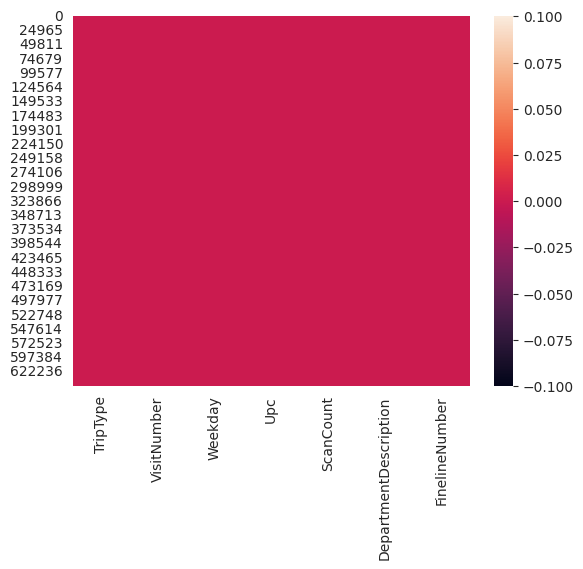

In [ ]:
sns.heatmap(train_data.isna())

## Univariate analysis

### TripType

In [ ]:
train_data.TripType.nunique()

38

38 different class labels

In [ ]:
train_data.TripType.unique()

array([999,  30,  26,   8,  35,  41,  21,   6,  42,   7,   9,  39,  25,
        38,  15,  36,  20,  37,  32,  40,   5,   3,   4,  24,  33,  43,
        31,  27,  34,  18,  29,  44,  19,  23,  22,  28,  14,  12])

<Axes: ylabel='count'>

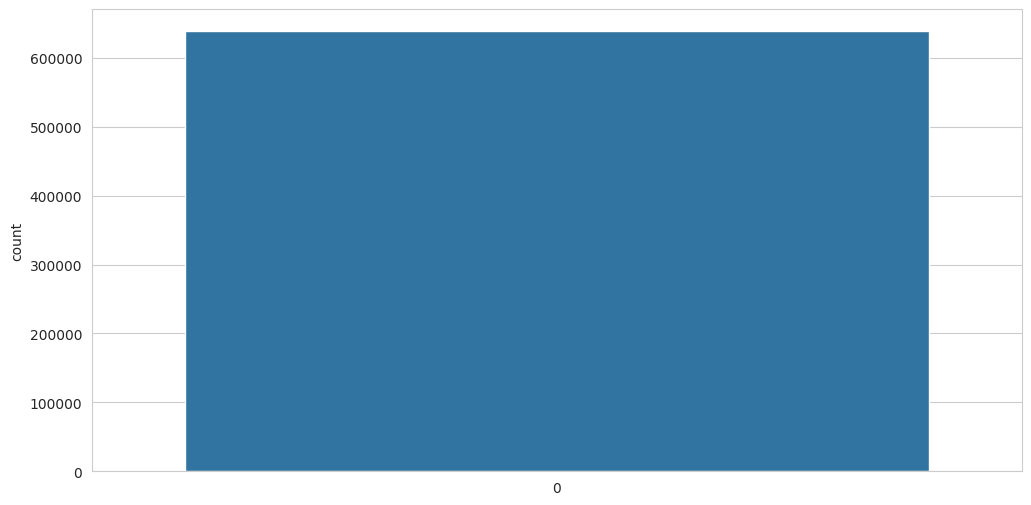

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(train_data.TripType)

<ipython-input-476-61a2a011733f>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data.TripType,hist=False)


<Axes: xlabel='TripType', ylabel='Density'>

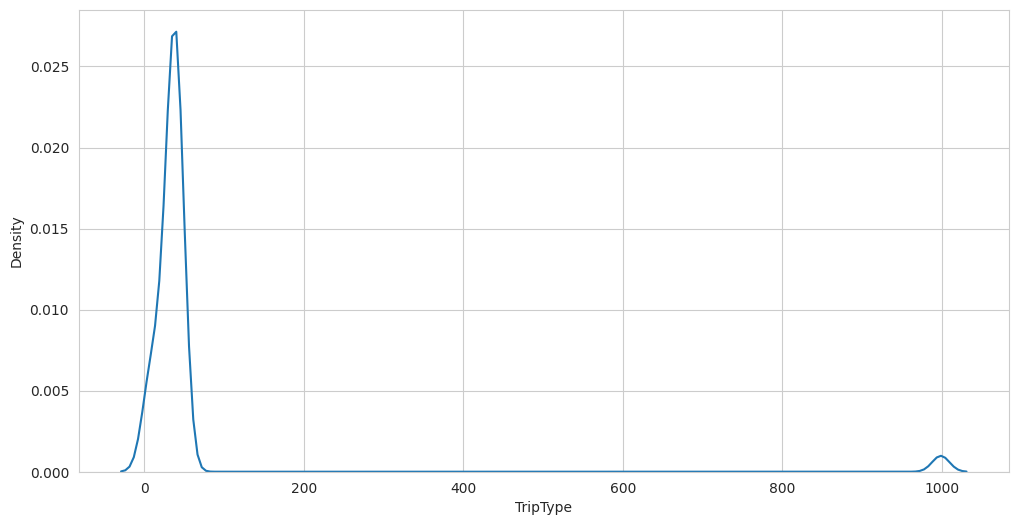

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(train_data.TripType,hist=False)

**Imbalanced data**. distribution of target variable is right skewed. there are too many classes for which there are very few datapoints
TripType 36 to 40 have most datapoints.

### VisitNumber

In [ ]:
train_data.VisitNumber.nunique()

94247

In [ ]:
train_data.shape[0]

638472

VisitNumber is a categorical variable

<ipython-input-479-2f34e1ab0cf1>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data.VisitNumber)


<Axes: xlabel='VisitNumber', ylabel='Density'>

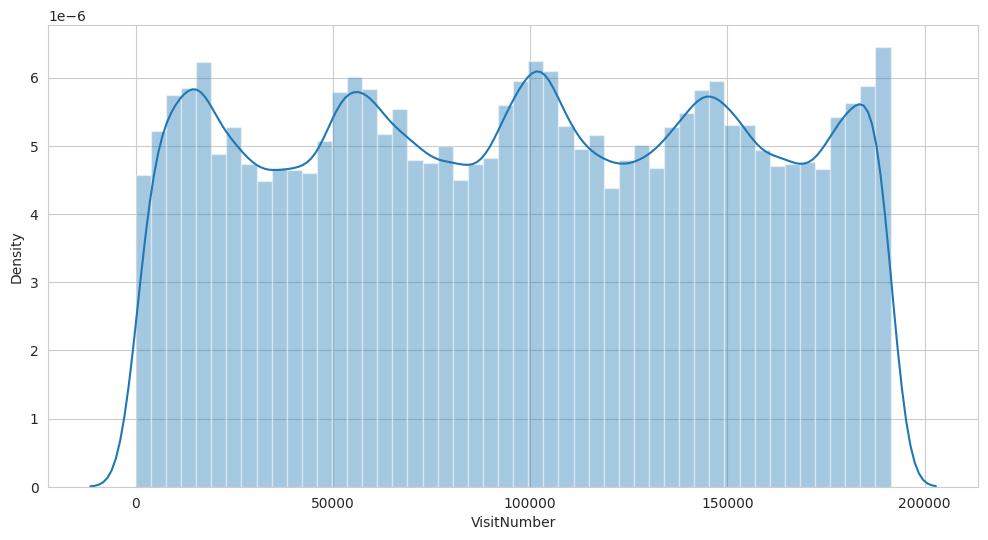

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(train_data.VisitNumber)

***VisitNumber shows approximately uniform distribution***

In [ ]:
train_data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


### Weekday distribution

In [ ]:
plt.figure(figsize=(12,6))
#sns.countplot(train_data.Weekday)

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [ ]:
train_data.groupby('Weekday')['Weekday'].count()

Weekday
Friday        94909
Monday        82020
Saturday     120568
Sunday       132571
Thursday      67045
Tuesday       71365
Wednesday     69994
Name: Weekday, dtype: int64

In [ ]:
def weekday_to_num(x):
  if x=='Monday':
    return 0
  elif x=='Tuesday':
    return 1
  elif x=='Wednesday':
    return 2
  elif x=='Thursday':
    return 3
  elif x=='Friday':
    return 4
  elif x=='Saturday':
    return 5
  elif x=='Sunday':
    return 6

In [ ]:
train_data['weekday_num']=train_data.Weekday.apply(weekday_to_num)

In [ ]:
train_data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4


In [ ]:
train_data.Weekday.unique()

array(['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday'], dtype=object)

<ipython-input-487-dd9507e464d0>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['weekday_num'],ax=axs)


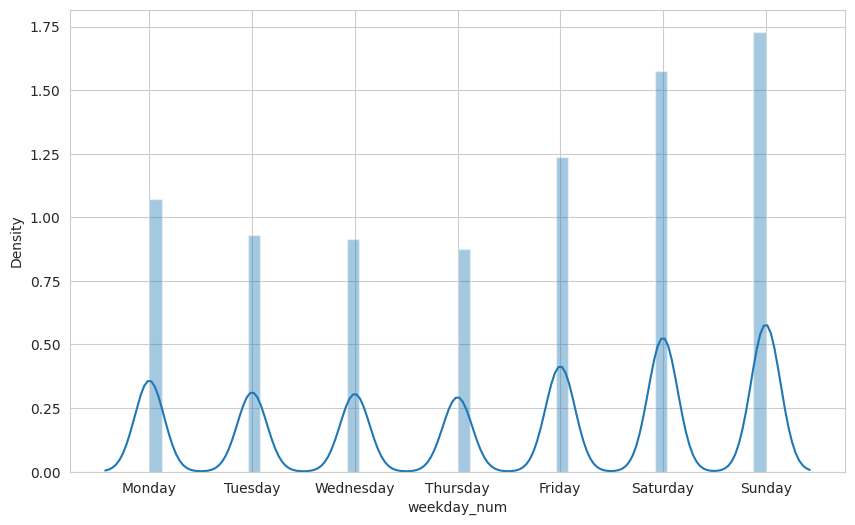

In [ ]:
fig,axs=plt.subplots(figsize=(10,6))
sns.distplot(train_data['weekday_num'],ax=axs)
ticks=list(range(0,7))
axs.set_xticks(ticks)
x_tick_label=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
axs.set_xticklabels(x_tick_label)
plt.show()

***As Expected there is more probabilty of visits for weekends. Thursday is the day for lowest number of visits***

### ScanCount

In [ ]:
train_data.ScanCount.nunique()

39

In [ ]:
train_data.ScanCount.value_counts()

 1     553701
 2      52771
-1      13920
 3       9406
 4       4525
 5       1377
 6        864
-2        791
 8        246
 7        228
-3        136
 10       130
 9         88
-4         73
 12        60
 11        45
-5         16
 14        15
 13        13
 15        12
-6          9
 20         7
 16         6
 19         4
 18         4
 24         4
 23         3
 17         3
 25         3
 22         2
-9          2
 71         1
 51         1
 30         1
 31         1
-7          1
 46         1
-12         1
-10         1
Name: ScanCount, dtype: int64

In [ ]:
train_data.min().ScanCount

-12

In [ ]:
train_data.max().ScanCount

71

<ipython-input-492-a9ae075047c6>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data.ScanCount,bins=39)


<Axes: xlabel='ScanCount', ylabel='Density'>

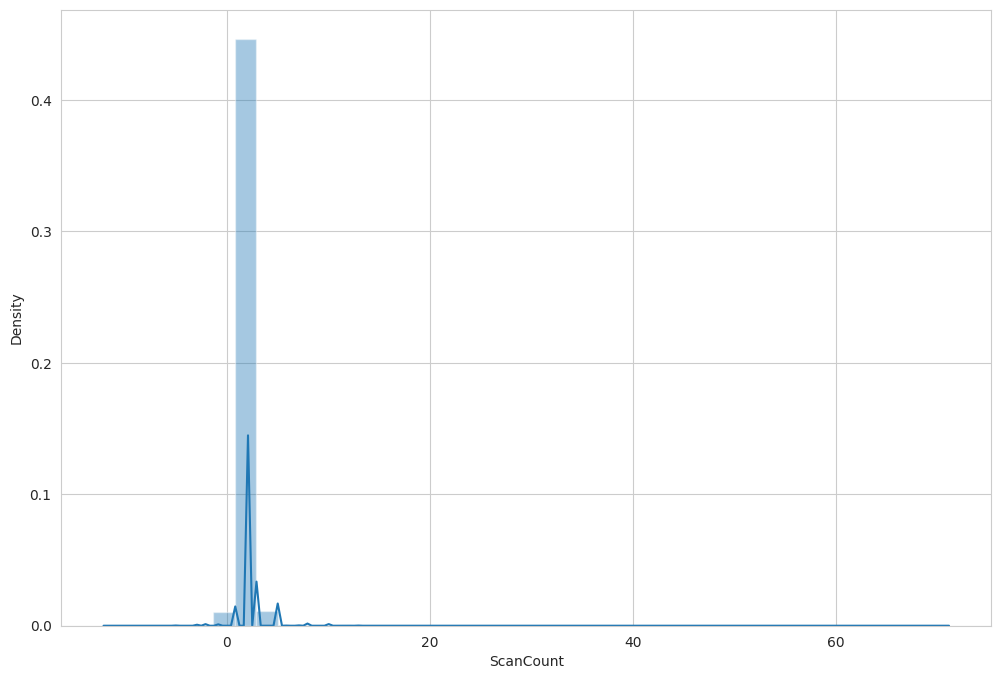

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(train_data.ScanCount,bins=39)

***ScanCount data is widely distributed between -12 to 71. 71 seems to be an outlier. so to get clearer view of the distribution plottting distribution in two parts***

<ipython-input-493-b95014d1a221>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data[train_data.ScanCount<=10].ScanCount)


<Axes: xlabel='ScanCount', ylabel='Density'>

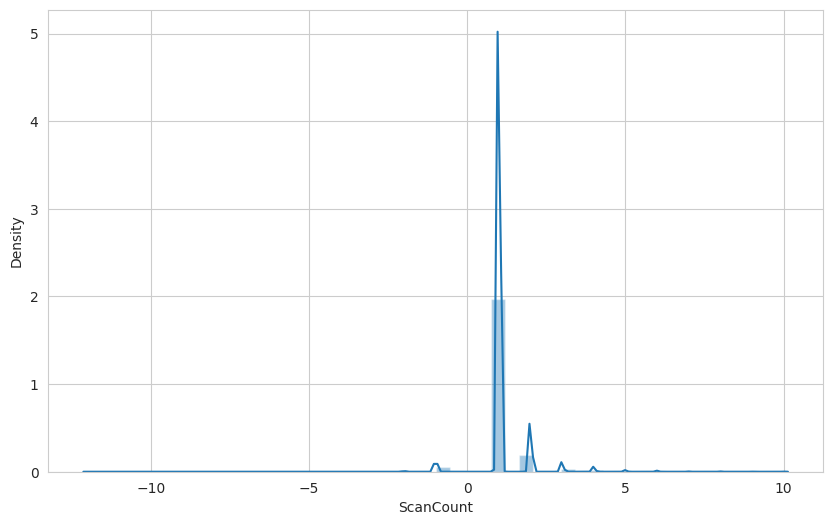

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(train_data[train_data.ScanCount<=10].ScanCount)


<ipython-input-494-b5c43ac51571>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data[train_data.ScanCount>10].ScanCount,bins=4)


<Axes: xlabel='ScanCount', ylabel='Density'>

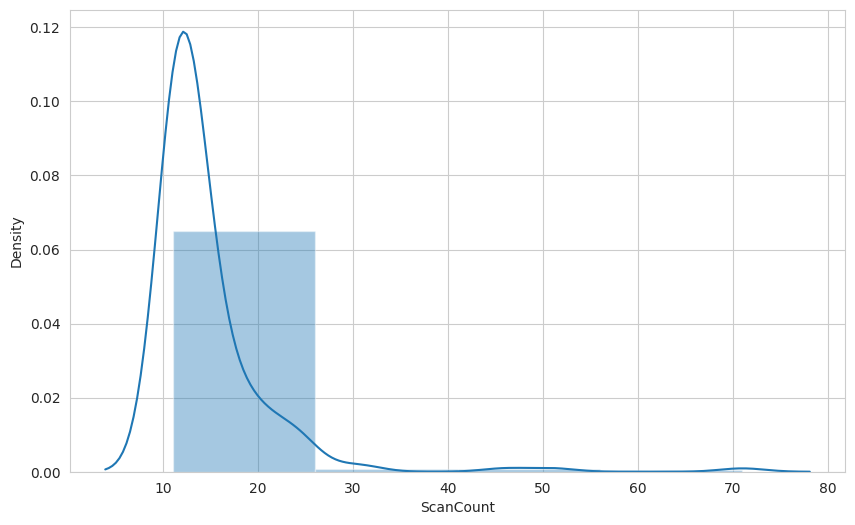

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(train_data[train_data.ScanCount>10].ScanCount,bins=4)


<Axes: ylabel='count'>

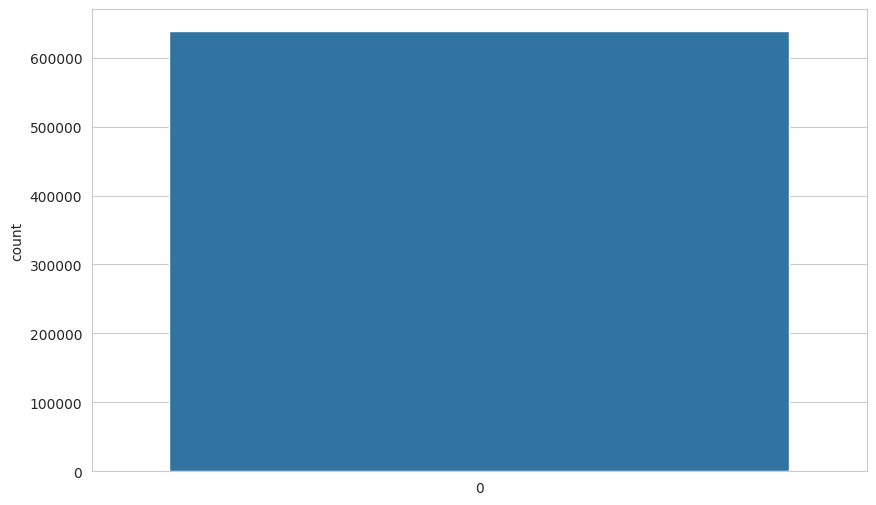

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(train_data[train_data.ScanCount<=10].ScanCount)

In [ ]:
plt.figure(figsize=(10,6))
#sns.countplot(train_data[train_data.ScanCount>10].ScanCount)

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

***As we can see, there are visits for ScanCount of 1 the most. and as number of ScanCount increases, the count of data points decreases. Also not many data points for returned products, since negative ScanCounts are not much.***

In [ ]:
train_data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4


### DepartmentDescription

In [ ]:
train_data.DepartmentDescription.nunique()

68

In [ ]:
train_data.DepartmentDescription.value_counts()

GROCERY DRY GOODS         70034
DSD GROCERY               67682
PRODUCE                   50826
DAIRY                     43599
PERSONAL CARE             41887
                          ...  
LARGE HOUSEHOLD GOODS        77
CONCEPT STORES               35
OTHER DEPARTMENTS            29
SEASONAL                     29
HEALTH AND BEAUTY AIDS        2
Name: DepartmentDescription, Length: 68, dtype: int64

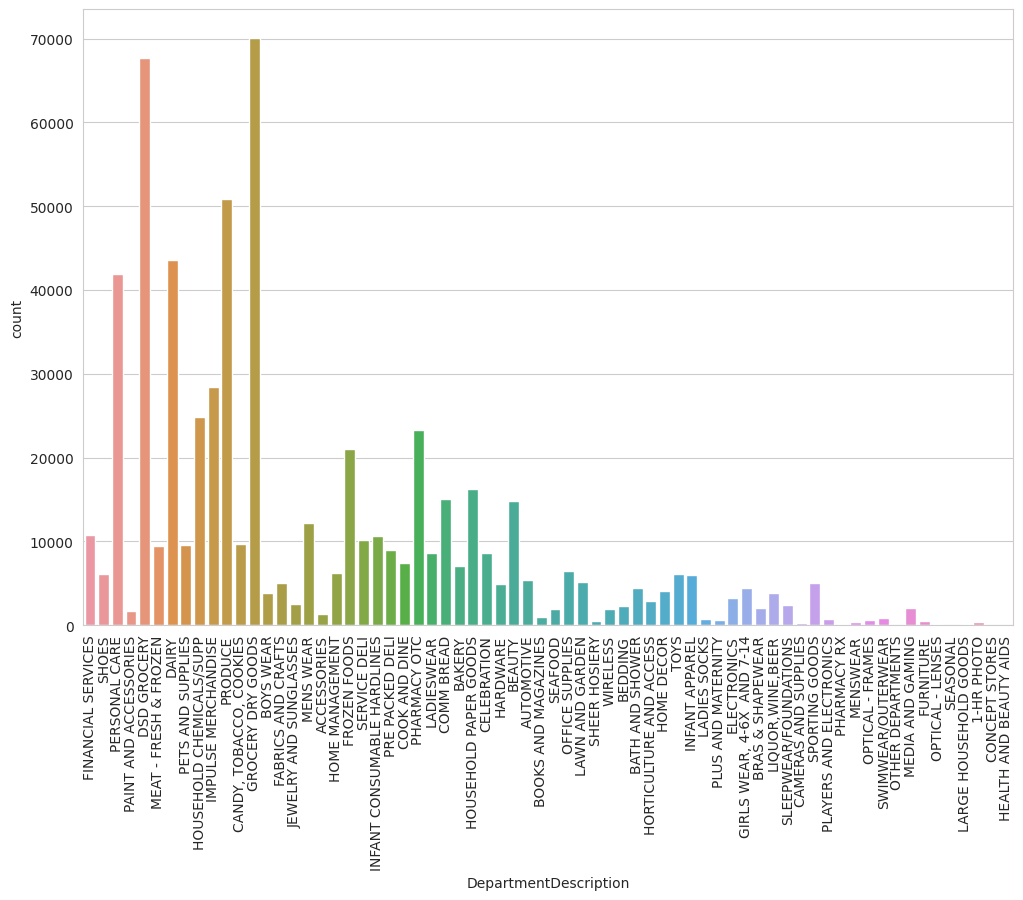

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x='DepartmentDescription',data=train_data)
plt.xticks(rotation=90)
plt.show()

In [ ]:
train_data.groupby('DepartmentDescription')['DepartmentDescription'].count()

DepartmentDescription
1-HR PHOTO                387
ACCESSORIES              1294
AUTOMOTIVE               5366
BAKERY                   7109
BATH AND SHOWER          4426
                         ... 
SLEEPWEAR/FOUNDATIONS    2352
SPORTING GOODS           5031
SWIMWEAR/OUTERWEAR        859
TOYS                     6042
WIRELESS                 1889
Name: DepartmentDescription, Length: 68, dtype: int64

In [ ]:
department_list=list(train_data['DepartmentDescription'].unique())

In [ ]:
department_enumerate=list(enumerate(department_list))

In [ ]:
department_dict={v:k for k,v in department_enumerate}

In [ ]:
department_dict.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67])

In [ ]:
def department_num(x):
  return department_dict[x]


In [ ]:
train_data['Department_num']=train_data['DepartmentDescription'].apply(department_num)

In [ ]:
train_data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3


<ipython-input-509-0166d5e79433>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['Department_num'],bins=68,ax=axs)


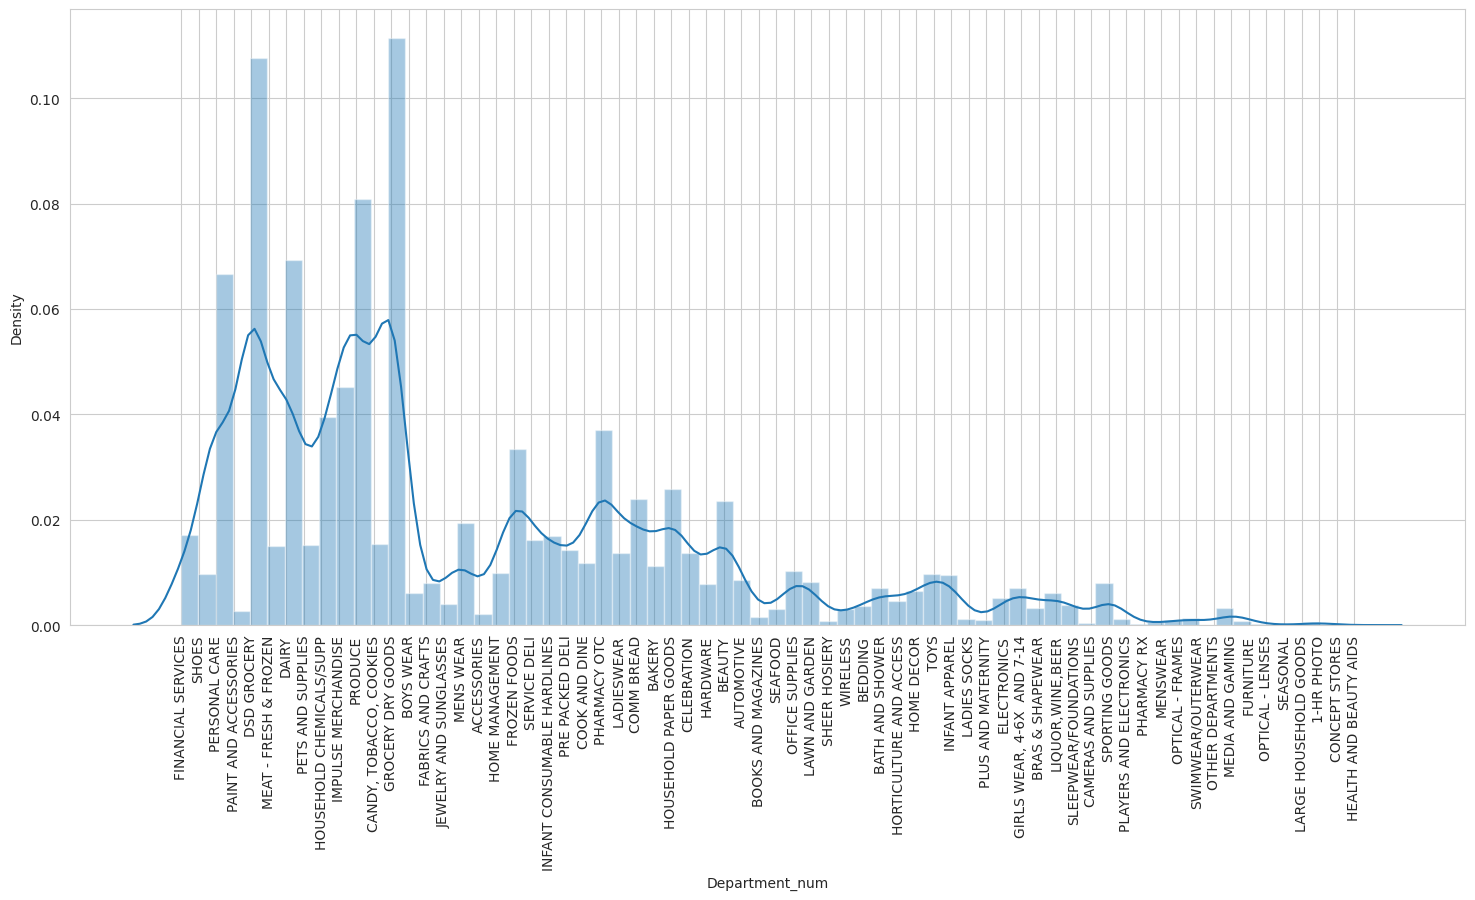

In [ ]:
fig,axs=plt.subplots(figsize=(18,8))
sns.distplot(train_data['Department_num'],bins=68,ax=axs)
ticks=list(range(0,68))
axs.set_xticks(ticks)
x_tick_label=train_data.DepartmentDescription.unique()
axs.set_xticklabels(x_tick_label)
plt.xticks(rotation=90)
plt.show()



Distribution of DepartmentDescription in **skewed**, **PERSONAL CARE, DSD GROCERIES, DAIRY, PRODUCE, GROCERY DRY GOODS** these categories in DepartmentDescription dominate the data.

### FinelineNumber

In [ ]:
train_data.nunique().FinelineNumber

5195

Too many categories in FinelineNumber

<ipython-input-511-e71ed02763f0>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data.FinelineNumber,hist=False)


<Axes: xlabel='FinelineNumber', ylabel='Density'>

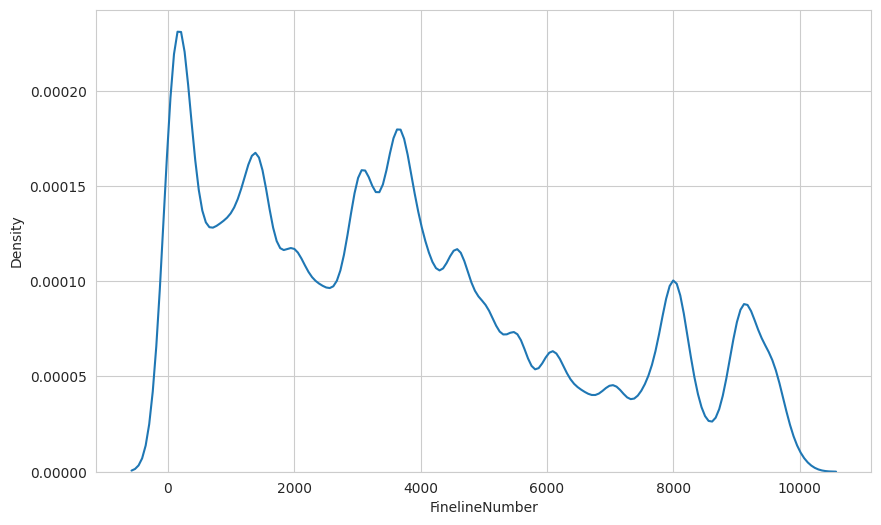

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(train_data.FinelineNumber,hist=False)

we may say that this is a multimodal distribution. certain values appear more frequently than others.

### Upc

In [ ]:
train_data.Upc.nunique()

97714

In [ ]:
train_data.shape

(638472, 9)

<ipython-input-514-282f9e77f50d>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data.Upc,hist=False)


<Axes: xlabel='Upc', ylabel='Density'>

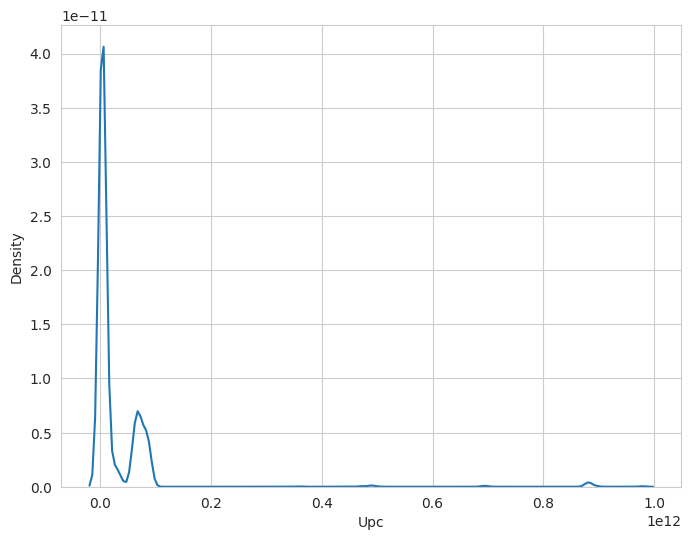

In [ ]:
plt.figure(figsize=(8,6))
sns.distplot(train_data.Upc,hist=False)

In [ ]:
train_data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3


# featurization

### creating a new feature 'num_of_products' which shows number of products purchased for each 'VisitNumber' based on 'Upc'

In [ ]:
# seeing for each VisitNumber how many products were purchased based on Upc number of product purchased
products_per_visit=train_data.groupby(['VisitNumber'])['Upc'].count()

In [ ]:
products_per_visit_dict=dict(products_per_visit)

In [ ]:
train_data['num_of_products_for_VisitNumber']=train_data['VisitNumber'].apply(lambda x:products_per_visit_dict.get(x,0))

In [ ]:
# train_data.drop(columns=['num_of_products'],inplace=True)

In [ ]:
train_data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0,1
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1,2
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2,2
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3,22
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3,22


In [ ]:
train_data.num_of_products_for_VisitNumber.nunique()

101

<ipython-input-522-291dba961bb7>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data.num_of_products_for_VisitNumber,bins=99)


<Axes: xlabel='num_of_products_for_VisitNumber', ylabel='Density'>

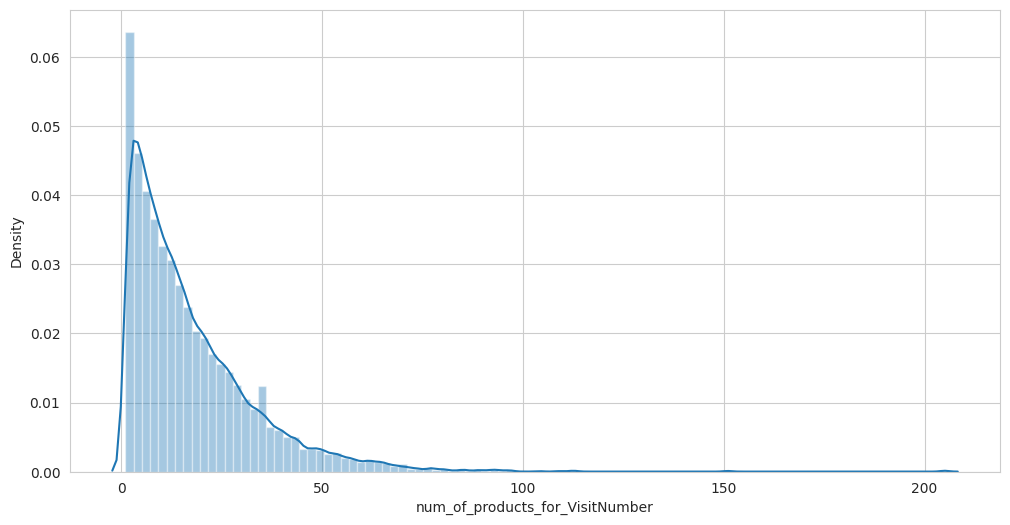

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(train_data.num_of_products_for_VisitNumber,bins=99)

As expected the distribution of number of products purchased for each VisitNumer is right skewed. there is more probability of buying less number of products

Seems like num_of_products purchased shows lognormal distribution, checking for same.

<ipython-input-523-e9e59f8b3361>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(train_data.num_of_products_for_VisitNumber),hist=False)


<Axes: xlabel='num_of_products_for_VisitNumber', ylabel='Density'>

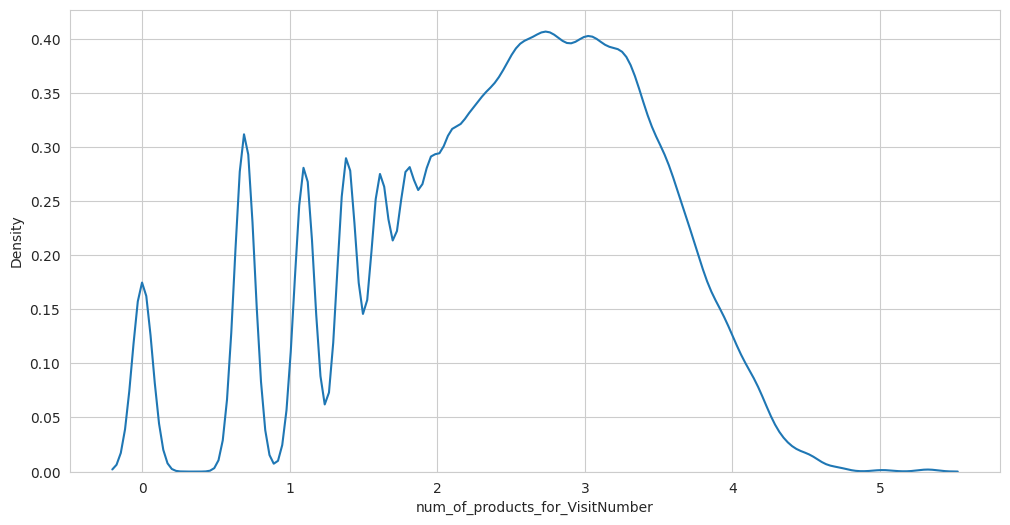

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(np.log(train_data.num_of_products_for_VisitNumber),hist=False)

num_of_products does not show lognormal distribution.

Checking if num_of_products is somehow related to the day on which shopping was done.

In [ ]:
train_data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0,1
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1,2
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2,2
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3,22
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3,22


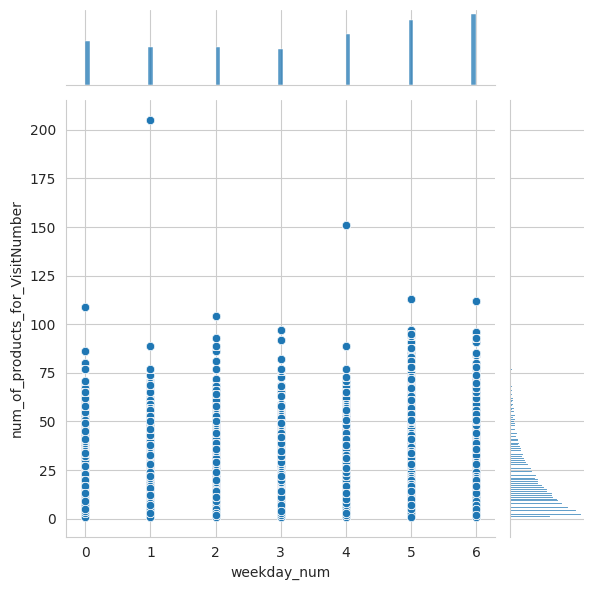

In [ ]:
sns.jointplot(y='num_of_products_for_VisitNumber',x='weekday_num',data=train_data)

<Axes: xlabel='weekday_num', ylabel='num_of_products_for_VisitNumber'>

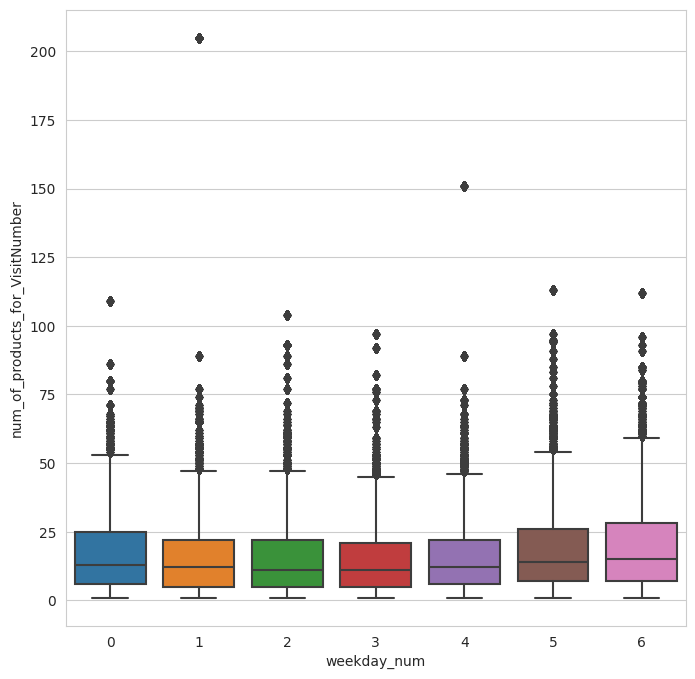

In [ ]:
plt.figure(figsize=(8,8))
sns.boxplot(x='weekday_num',y='num_of_products_for_VisitNumber',data=train_data)

On weekends and on mondays there seem to be more products bought per VisitNumber

In [ ]:
train_data.FinelineNumber.nunique()

5195

In [ ]:
train_data.Department_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67])

In [ ]:
groupby_dept=train_data.groupby(['Department_num'])

fineline_dict is dictionary where key is Depart_num and value is unique number of FinelineNumber in that department

In [ ]:
fineline_dict={}
for i in range(68):
  gr=groupby_dept.get_group(i)
  c=gr['FinelineNumber'].count()
  un=gr['FinelineNumber'].nunique()
  #print(f"group: {i}, unique FinelineNumber: {un}")
  fineline_dict[i]=un



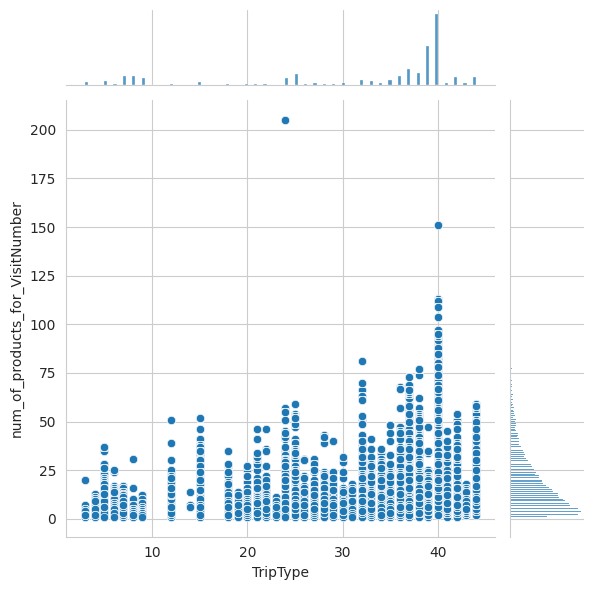

In [ ]:
sns.jointplot(y='num_of_products_for_VisitNumber',x='TripType',data=train_data[train_data['TripType']<900])

num_of_products seem to increase as category number of TripType increase.

<Axes: xlabel='TripType', ylabel='num_of_products_for_VisitNumber'>

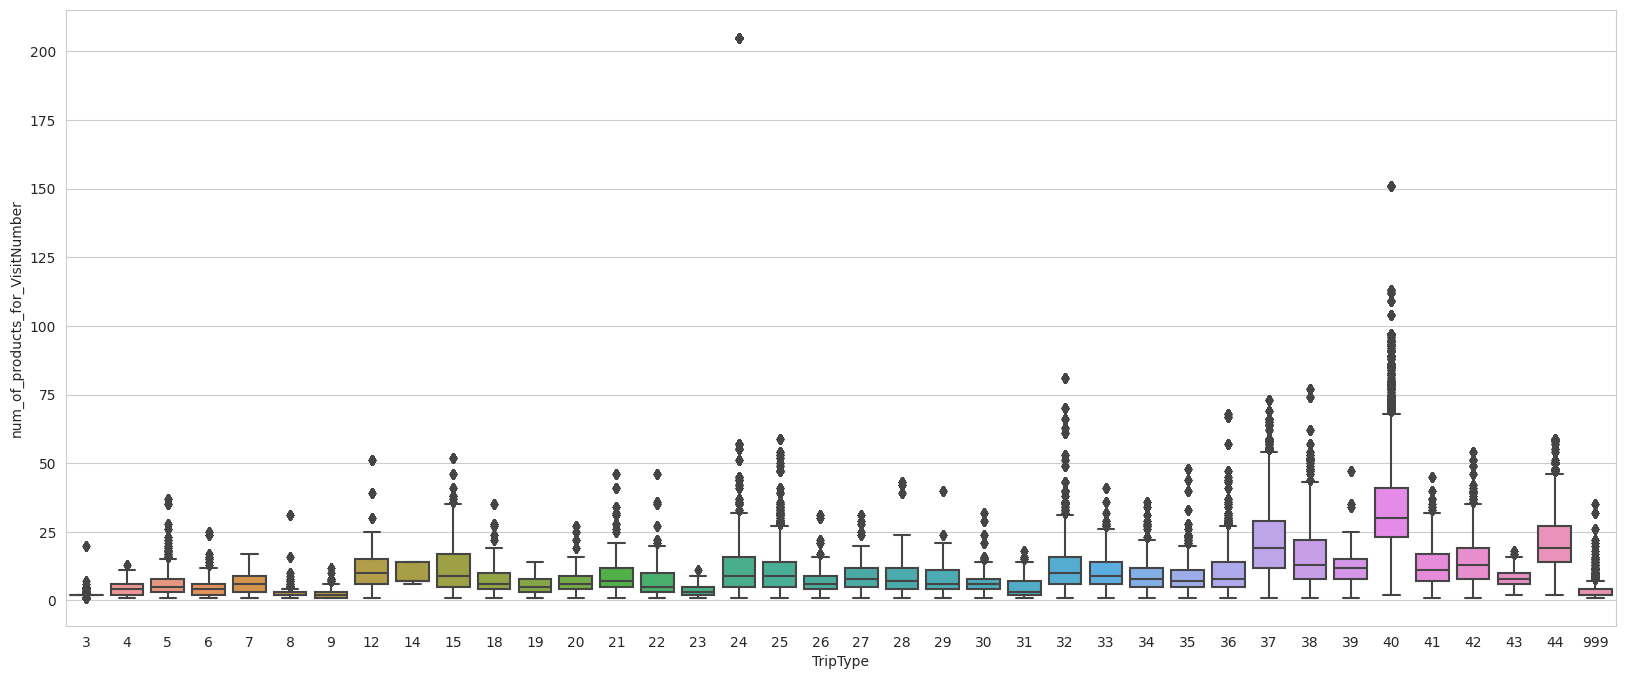

In [ ]:
plt.figure(figsize=(20,8))
sns.boxplot(x='TripType',y='num_of_products_for_VisitNumber',data=train_data)

**We do see a trend here, boxplots for various TripTypes for num_of_products don't fully overlap, hence num_of_products might prove to be an**

In [ ]:
train_data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0,1
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1,2
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2,2
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3,22
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3,22


<Axes: xlabel='TripType', ylabel='Department_num'>

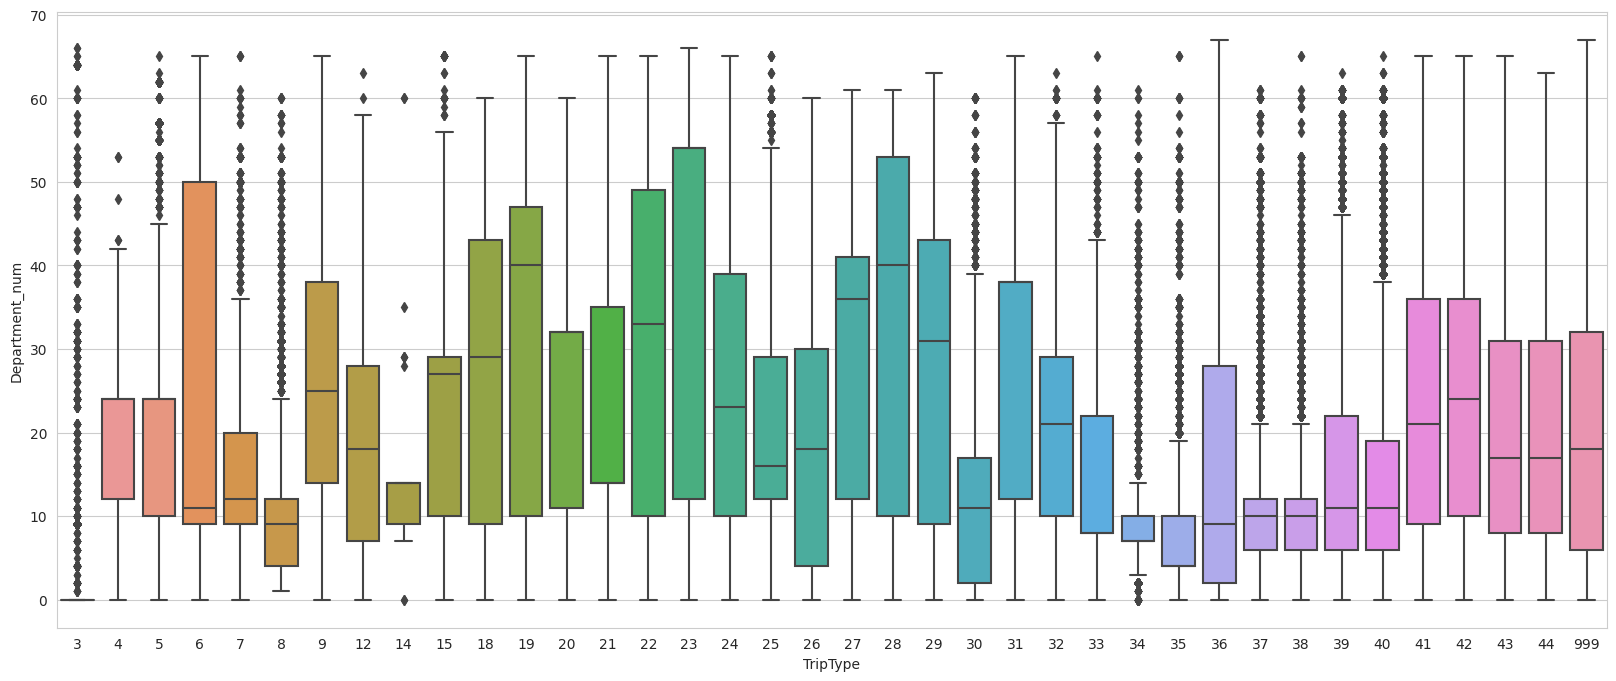

In [ ]:
plt.figure(figsize=(20,8))
sns.boxplot(x='TripType',y='Department_num',data=train_data)

**boxplots for various TripTypes for Department_num also don't fully overlap, hence num_of_products might prove to be an distinctive feature**

In [ ]:
weekday_num_of_products=dict(train_data.groupby('weekday_num')['Upc'].count())

In [ ]:
train_data['num_of_products_for_weekday']=train_data['weekday_num'].apply(lambda x:weekday_num_of_products.get(x))

In [ ]:
train_data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber,num_of_products_for_weekday
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0,1,94909
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1,2,94909
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2,2,94909
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3,22,94909
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3,22,94909


<Axes: xlabel='TripType', ylabel='num_of_products_for_weekday'>

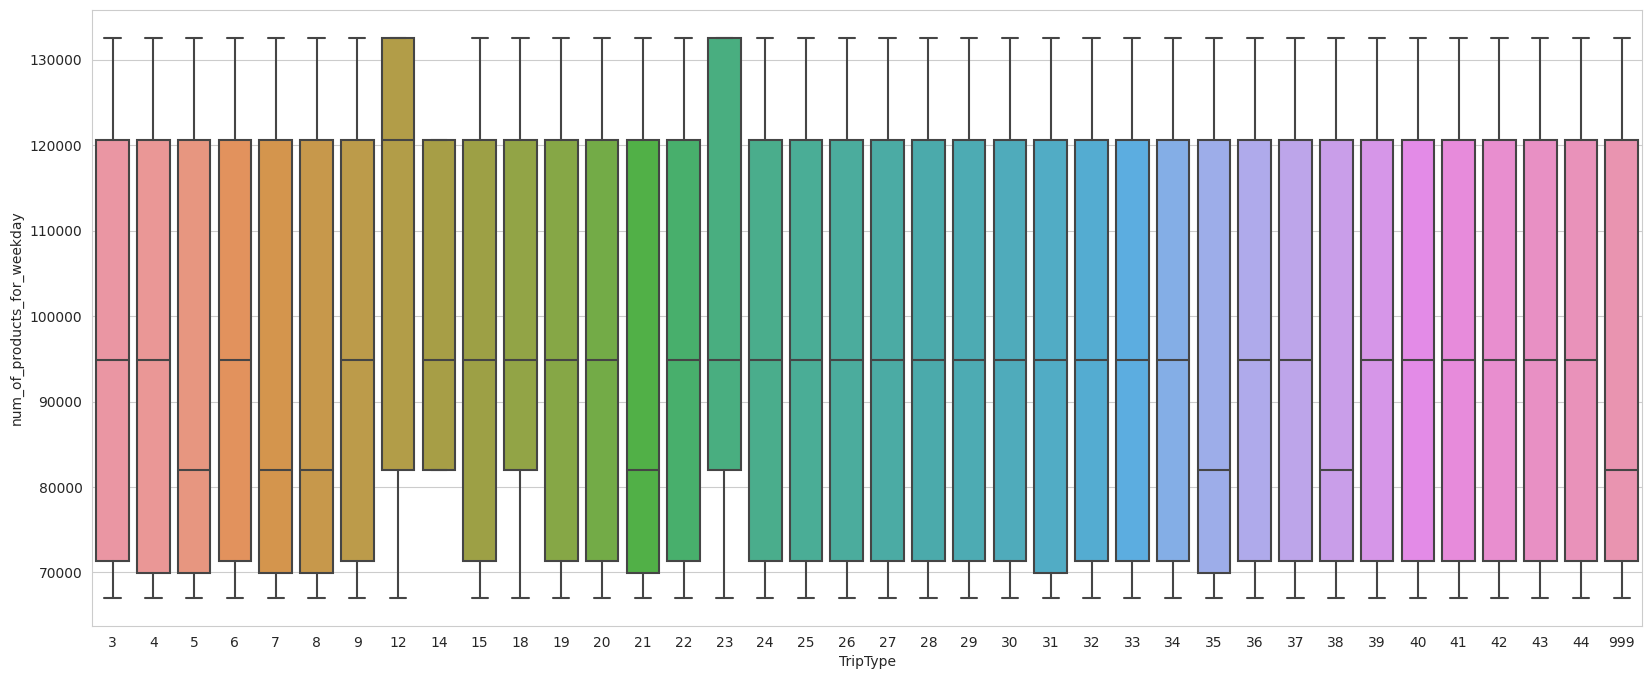

In [ ]:
plt.figure(figsize=(20,8))
sns.boxplot(x='TripType',y='num_of_products_for_weekday',data=train_data)

**'num_of_products_for weekday' does not seem to be much useful. removing it**

In [ ]:
train_data.drop(columns=['num_of_products_for_weekday'],inplace=True)

In [ ]:
Department_num_of_products=dict(train_data.groupby('Department_num')['Upc'].count())

In [ ]:
train_data['num_of_products_for_department']=train_data['Department_num'].apply(lambda x:Department_num_of_products.get(x))

<Axes: xlabel='TripType', ylabel='num_of_products_for_department'>

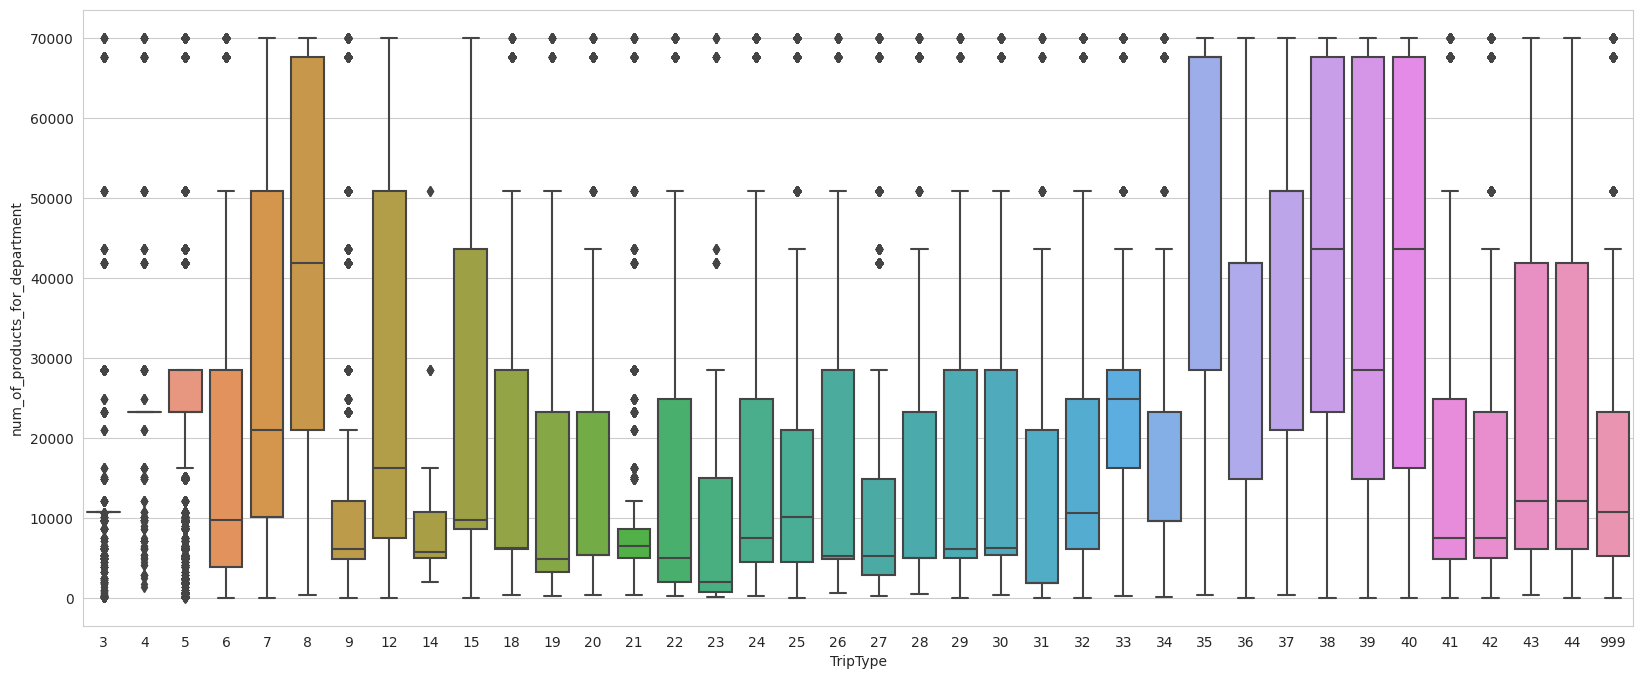

In [ ]:
plt.figure(figsize=(20,8))
sns.boxplot(x='TripType',y='num_of_products_for_department',data=train_data)

**'num_of_products_for_department' seems to be useful. keeping it.**

In [ ]:
train_data.FinelineNumber.nunique()

5195

In [ ]:
Fineline_num_of_products=dict(train_data.groupby('FinelineNumber')['Upc'].count())

In [ ]:
train_data['num_of_products_for_fineline']=train_data['FinelineNumber'].apply(lambda x:Fineline_num_of_products.get(x))

<Axes: xlabel='TripType', ylabel='num_of_products_for_fineline'>

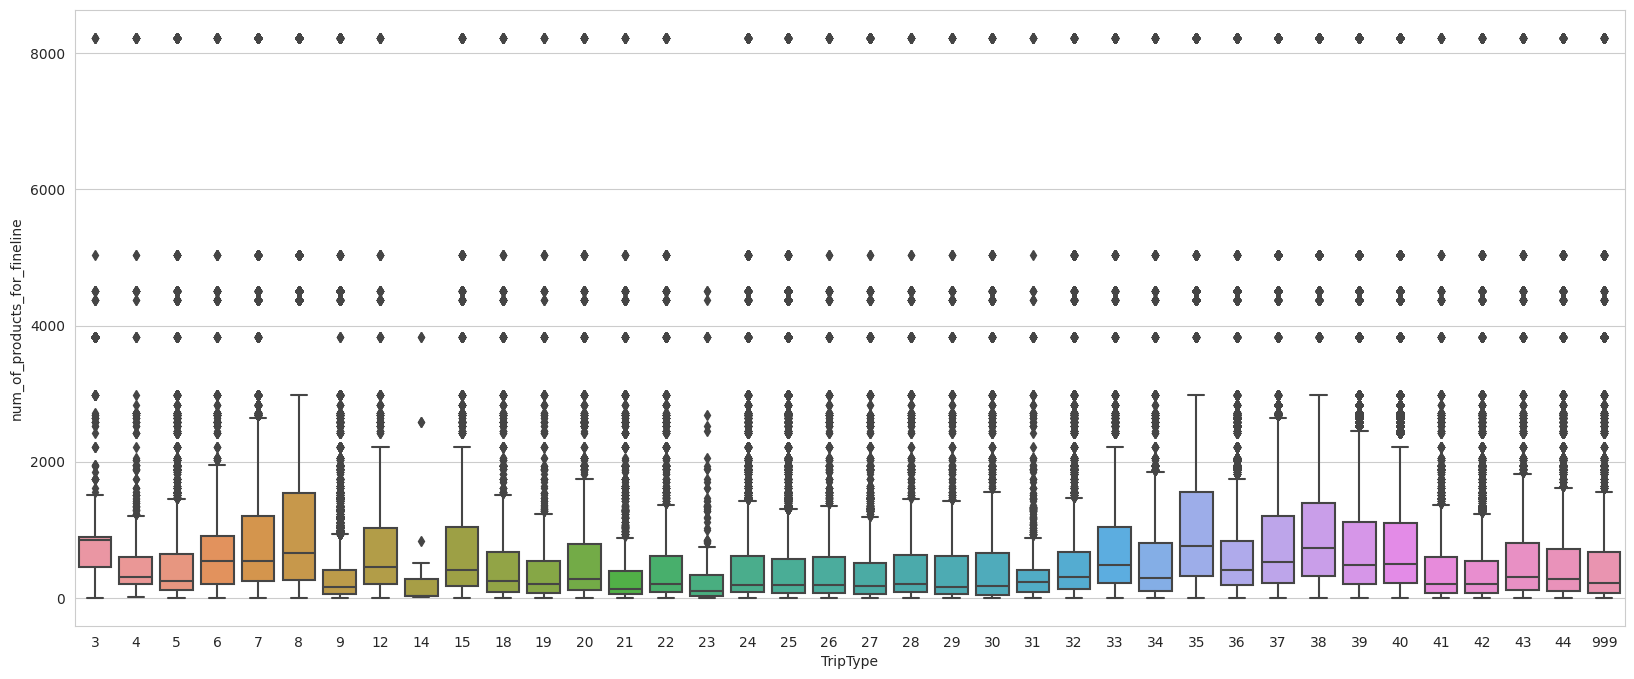

In [ ]:
plt.figure(figsize=(20,8))
sns.boxplot(x='TripType',y='num_of_products_for_fineline',data=train_data)

**'num_of_products_for_fineline' does not seem to be much useful removing it**

In [ ]:
train_data.drop(columns=['num_of_products_for_fineline'],inplace=True)

In [ ]:
train_data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber,num_of_products_for_department
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0,1,10713
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1,2,6056
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2,2,41887
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3,22,1698
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3,22,1698


In [ ]:
train_data.Weekday.value_counts()

Sunday       132571
Saturday     120568
Friday        94909
Monday        82020
Tuesday       71365
Wednesday     69994
Thursday      67045
Name: Weekday, dtype: int64

In [ ]:
train_data.DepartmentDescription.value_counts()

GROCERY DRY GOODS         70034
DSD GROCERY               67682
PRODUCE                   50826
DAIRY                     43599
PERSONAL CARE             41887
                          ...  
LARGE HOUSEHOLD GOODS        77
CONCEPT STORES               35
OTHER DEPARTMENTS            29
SEASONAL                     29
HEALTH AND BEAUTY AIDS        2
Name: DepartmentDescription, Length: 68, dtype: int64

In [ ]:
train_data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber,num_of_products_for_department
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0,1,10713
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1,2,6056
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2,2,41887
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3,22,1698
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3,22,1698


## **one hot encoding Weekdays**

In [ ]:
one_hot_encoded_weekday=pd.get_dummies(train_data['Weekday'],drop_first=False)

In [ ]:
one_hot_encoded_weekday.head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [ ]:
train_data=pd.concat([train_data,one_hot_encoded_weekday],axis=1)

In [ ]:
train_data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber,num_of_products_for_department,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0,1,10713,1,0,0,0,0,0,0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1,2,6056,1,0,0,0,0,0,0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2,2,41887,1,0,0,0,0,0,0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3,22,1698,1,0,0,0,0,0,0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3,22,1698,1,0,0,0,0,0,0


# Splitting data into X and Y and then into train and cross validation and test sets.

**adding 'FinelineCat' feature**

In [ ]:
Y=train_data.TripType

In [ ]:
X=train_data.drop(columns=['TripType'])

In [ ]:
X['FinelineCat']=pd.cut(X['FinelineNumber'],bins=50,labels=False)

In [ ]:
X.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber,num_of_products_for_department,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,FinelineCat
0,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0,1,10713,1,0,0,0,0,0,0,5
1,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1,2,6056,1,0,0,0,0,0,0,44
2,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2,2,41887,1,0,0,0,0,0,0,22
3,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3,22,1698,1,0,0,0,0,0,0,17
4,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3,22,1698,1,0,0,0,0,0,0,5


In [ ]:
Y.head()

0    999
1     30
2     30
3     26
4     26
Name: TripType, dtype: int64

In [ ]:
train_data.shape

(638472, 18)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,stratify=Y,test_size=0.2)
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,stratify=y_train,test_size=0.2)

In [ ]:
print(x_train.shape,x_cv.shape,x_test.shape)

(408621, 18) (102156, 18) (127695, 18)


In [ ]:
print(y_train.shape,y_cv.shape,y_test.shape)

(408621,) (102156,) (127695,)


# Response encoding for rest of the rest of the categorical features

### **Creating a new temporary dataframe from x_train and y_train for getting lookup table for response coding of some categorical features**

In [ ]:
x_train_res=x_train.copy()

In [ ]:
x_train_res['class']=y_train.values

In [ ]:
y_train.unique()

array([ 40,  39,  25,   7,  37,  24,  29,  38, 999,  44,  35,   3,   5,
         8,   9,  26,  36,  28,  20,  27,  42,  19,  32,  34,  15,  43,
        41,  22,   6,  30,  31,  18,  33,  21,  12,   4,  23,  14])

In [ ]:
x_train_res.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber,num_of_products_for_department,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,FinelineCat,class
613935,182910,Saturday,4.470002e+09,1,PRE PACKED DELI,7208.0,5,22,43,9004,0,0,1,0,0,0,0,36,40
431347,128505,Thursday,8.876618e+10,1,PHARMACY OTC,1611.0,3,24,8,23243,0,0,0,0,1,0,0,8,39
400488,118231,Tuesday,4.111601e+09,1,IMPULSE MERCHANDISE,110.0,1,9,11,28472,0,0,0,0,0,1,0,0,25
116834,34595,Wednesday,2.086700e+10,1,SERVICE DELI,8009.0,2,20,1,10110,0,0,0,0,0,0,1,40,7
229383,67716,Monday,7.848575e+10,2,BEDDING,8117.0,0,39,29,2243,0,1,0,0,0,0,0,40,40


### **Functions for response encoding**

In [ ]:
#function to get lookup dictionary based on train data only
from tqdm import tqdm
def get_lookup_dict(alpha,feature):
  value_count = x_train_res[feature].value_counts()
  lookup_dict = dict()
  for i, denominator in tqdm(value_count.items()):
    vec = []
    for k in y_train.unique():
      cls_cnt = x_train_res.loc[(x_train_res['class']==k) & (x_train_res[feature]==i)]
      vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

    lookup_dict[i]=vec

  return lookup_dict


In [ ]:
from tqdm import tqdm
def get_encoded_feature(alpha,feature,df,lookup_dict):
  #lookup_dict=get_lookup_dict(alpha,feature,df)
  value_count = x_train_res[feature].value_counts()
  gv_fea = []
  for index, row in tqdm(df.iterrows()):

    if row[feature] in dict(value_count).keys():
        gv_fea.append(lookup_dict[row[feature]])
    else:
        gv_fea.append([1/38]*38)
#           gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])

  return gv_fea

### **response encoding 'DepartmentDescription'**

In [ ]:
lookup_dict_DD=get_lookup_dict(1,'DepartmentDescription')

68it [01:16,  1.13s/it]


In [ ]:
alpha = 1
train_department_feature_responseCoding=np.array(get_encoded_feature(alpha, "DepartmentDescription", x_train,lookup_dict_DD))

408621it [01:43, 3947.16it/s]


In [ ]:
test_department_feature_responseCoding=np.array(get_encoded_feature(alpha, "DepartmentDescription", x_test,lookup_dict_DD))

127695it [00:31, 4038.70it/s]


In [ ]:
cv_department_feature_responseCoding=np.array(get_encoded_feature(alpha, "DepartmentDescription", x_cv,lookup_dict_DD))

102156it [00:25, 3947.53it/s]


In [ ]:
train_department_feature_responseCoding.shape

(408621, 38)

In [ ]:
test_department_feature_responseCoding.shape

(127695, 38)

In [ ]:
cv_department_feature_responseCoding.shape

(102156, 38)

### **response encoding 'ScanCount'**

In [ ]:
train_data.ScanCount.nunique()

39

In [ ]:
lookup_dict_SS=get_lookup_dict(1,'ScanCount')

33it [00:01, 20.18it/s]


In [ ]:
train_ScanCount_feature_responseCoding=np.array(get_encoded_feature(alpha, "ScanCount", x_train,lookup_dict_SS))

408621it [01:03, 6399.91it/s]


In [ ]:
test_ScanCount_feature_responseCoding=np.array(get_encoded_feature(alpha, "ScanCount", x_test,lookup_dict_SS))

127695it [00:18, 6735.56it/s]


In [ ]:
cv_ScanCount_feature_responseCoding=np.array(get_encoded_feature(alpha, "ScanCount", x_cv,lookup_dict_SS))

102156it [00:15, 6621.74it/s]


In [ ]:
train_ScanCount_feature_responseCoding.shape

(408621, 38)

In [ ]:
test_ScanCount_feature_responseCoding.shape

(127695, 38)

In [ ]:
cv_ScanCount_feature_responseCoding.shape

(102156, 38)

### **response encoding 'FinelineCat'**

In [ ]:
train_data.FinelineNumber.nunique()

5195

'FinelineNumber' has too many categories. we will try to discretise it further into small number of categories

In [ ]:
train_data.FinelineNumber

0         1000.0
1         8931.0
2         4504.0
3         3565.0
4         1017.0
           ...  
647049    1118.0
647050    1752.0
647051    4170.0
647052    1512.0
647053    3600.0
Name: FinelineNumber, Length: 638472, dtype: float64

In [ ]:
train_data['FinelineCat']=pd.cut(train_data['FinelineNumber'],bins=50,labels=False)

<ipython-input-589-237e6d5e08f4>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['FinelineCat'])


<Axes: xlabel='FinelineCat', ylabel='Density'>

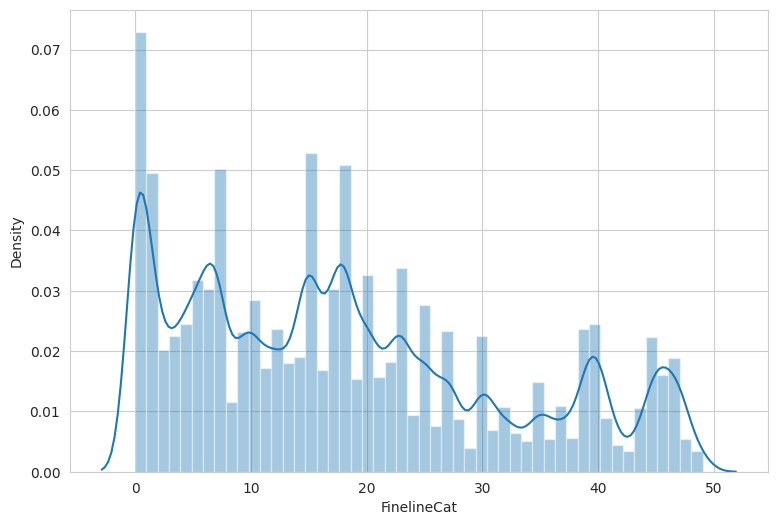

In [ ]:
plt.figure(figsize=(9,6))
sns.distplot(train_data['FinelineCat'])

we will see if this new feature is useful in classification

<Axes: xlabel='TripType', ylabel='FinelineCat'>

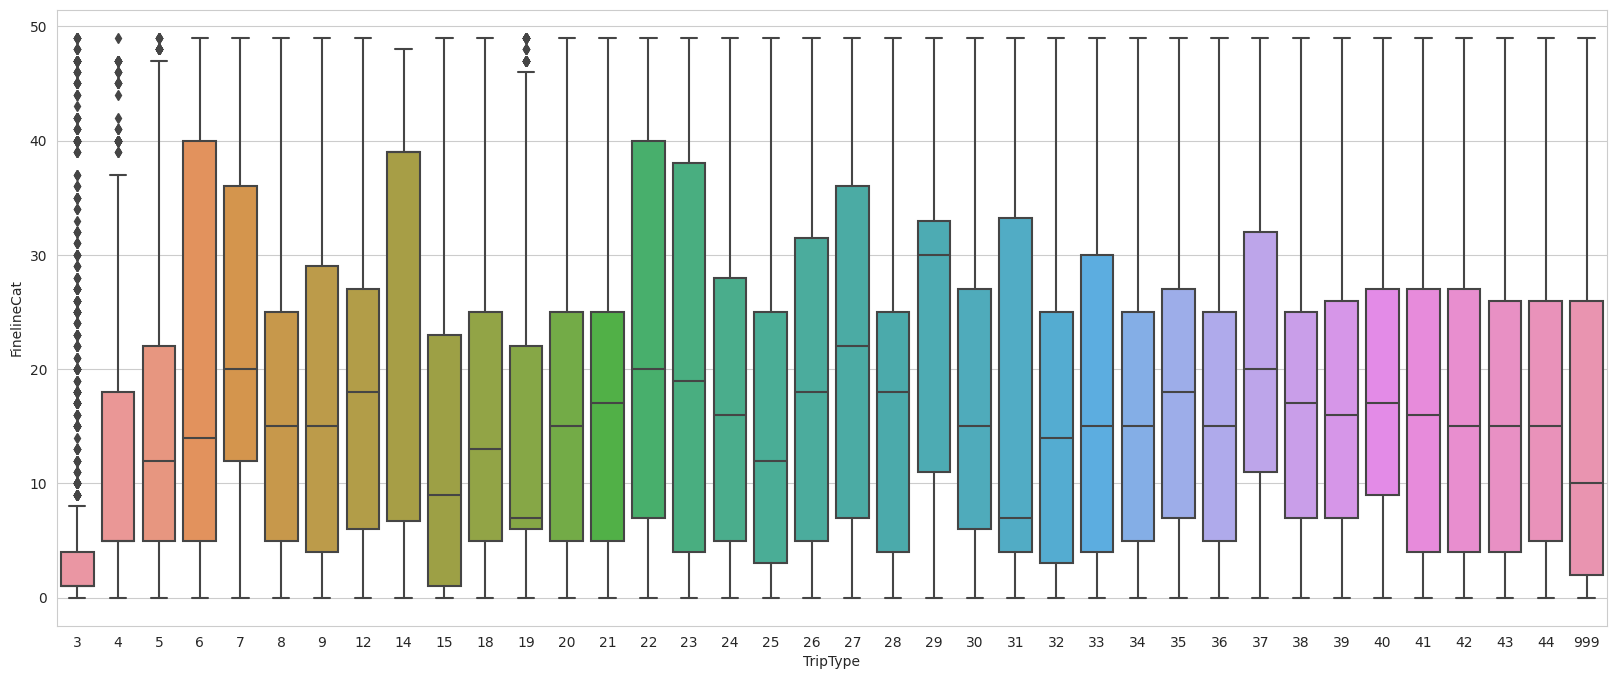

In [ ]:
plt.figure(figsize=(20,8))
sns.boxplot(x='TripType',y='FinelineCat',data=train_data)

Not much useful. but we will anyway respose encode this feature

we will need to add this feature to X first

In [ ]:
lookup_dict_FNC=get_lookup_dict(1,'FinelineCat')

50it [00:02, 18.98it/s]


In [ ]:
train_FinelineCat_feature_responseCoding=np.array(get_encoded_feature(alpha, "FinelineCat", x_train,lookup_dict_FNC))

408621it [01:23, 4886.11it/s]


In [ ]:
test_FinelineCat_feature_responseCoding=np.array(get_encoded_feature(alpha, "FinelineCat", x_test,lookup_dict_FNC))

127695it [00:26, 4817.96it/s]


In [ ]:
cv_FinelineCat_feature_responseCoding=np.array(get_encoded_feature(alpha, "FinelineCat", x_cv,lookup_dict_FNC))

102156it [00:20, 5098.83it/s]


In [ ]:
train_FinelineCat_feature_responseCoding.shape

(408621, 38)

In [ ]:
test_FinelineCat_feature_responseCoding.shape

(127695, 38)

In [ ]:
cv_FinelineCat_feature_responseCoding.shape

(102156, 38)

# Stacking all featurized train, test and cv data and preparing final data.

In [ ]:
x_train.shape

(408621, 18)

In [ ]:
x_train.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber,num_of_products_for_department,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,FinelineCat
613935,182910,Saturday,4.470002e+09,1,PRE PACKED DELI,7208.0,5,22,43,9004,0,0,1,0,0,0,0,36
431347,128505,Thursday,8.876618e+10,1,PHARMACY OTC,1611.0,3,24,8,23243,0,0,0,0,1,0,0,8
400488,118231,Tuesday,4.111601e+09,1,IMPULSE MERCHANDISE,110.0,1,9,11,28472,0,0,0,0,0,1,0,0
116834,34595,Wednesday,2.086700e+10,1,SERVICE DELI,8009.0,2,20,1,10110,0,0,0,0,0,0,1,40
229383,67716,Monday,7.848575e+10,2,BEDDING,8117.0,0,39,29,2243,0,1,0,0,0,0,0,40


In [ ]:
x_train.drop(columns=['Weekday','Upc','DepartmentDescription','FinelineNumber','weekday_num','Department_num','FinelineCat'],inplace=True)

In [ ]:
x_train.head()

,VisitNumber,ScanCount,num_of_products_for_VisitNumber,num_of_products_for_department,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
613935,182910,1,43,9004,0,0,1,0,0,0,0
431347,128505,1,8,23243,0,0,0,0,1,0,0
400488,118231,1,11,28472,0,0,0,0,0,1,0
116834,34595,1,1,10110,0,0,0,0,0,0,1
229383,67716,2,29,2243,0,1,0,0,0,0,0


In [ ]:
x_train.values

array([[182910,      1,     43, ...,      0,      0,      0],
       [128505,      1,      8, ...,      1,      0,      0],
       [118231,      1,     11, ...,      0,      1,      0],
       ...,
       [104644,     -1,      6, ...,      0,      0,      0],
       [  7084,      3,     11, ...,      0,      0,      0],
       [110662,      1,     15, ...,      0,      0,      0]])

In [ ]:
train_department_feature_responseCoding.shape

(408621, 38)

In [ ]:
#random_indices = np.random.choice(x_train_dense.shape[0], size=train_ScanCount_feature_responseCoding.shape[0], replace=False)
x_train_dense_sampled = x_train_dense[random_indices, :]

# 進行串聯
x_tr = np.hstack((x_train_dense_sampled, train_ScanCount_feature_responseCoding, train_department_feature_responseCoding, train_FinelineCat_feature_responseCoding))
x_tr=np.hstack((x_train.values,train_ScanCount_feature_responseCoding,train_department_feature_responseCoding,train_FinelineCat_feature_responseCoding,))

In [ ]:
x_tr.shape

(408621, 125)

In [ ]:
y_train.shape

(408621,)

In [ ]:
x_test.drop(columns=['Weekday','Upc','DepartmentDescription','FinelineNumber','weekday_num','Department_num','FinelineCat'],inplace=True)

In [ ]:
x_test.head()

,VisitNumber,ScanCount,num_of_products_for_VisitNumber,num_of_products_for_department,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
610285,181904,1,2,6504,0,0,1,0,0,0,0
615468,183290,1,11,70034,0,0,1,0,0,0,0
608843,181530,1,61,70034,0,0,1,0,0,0,0
142157,42845,1,11,16211,0,0,0,0,1,0,0
447698,133685,1,9,23243,1,0,0,0,0,0,0


In [ ]:
x_te=np.hstack((x_test.values,test_ScanCount_feature_responseCoding,test_department_feature_responseCoding,test_FinelineCat_feature_responseCoding,))

In [ ]:
x_cv.drop(columns=['Weekday','Upc','DepartmentDescription','FinelineNumber','weekday_num','Department_num','FinelineCat'],inplace=True)

In [ ]:
x_cv=np.hstack((x_cv.values,cv_ScanCount_feature_responseCoding,cv_department_feature_responseCoding,cv_FinelineCat_feature_responseCoding,))

In [ ]:
x_cv.shape

(102156, 125)

In [ ]:
y_cv.shape

(102156,)

## saving the three preprocessed and featurized train, test and cv datasets for future importing.

In [ ]:
np.save('x_train_final',x_tr)

In [ ]:
np.save('x_test_final',x_te)

In [ ]:
np.save('x_cv_final',x_cv)

In [ ]:
np.save('y_train_final',y_train.values)

In [ ]:
np.save('y_test_final',y_test.values)

In [ ]:
np.save('y_cv_final',y_cv.values)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## loading .npy files

In [ ]:
from scipy import sparse

In [ ]:
x_cv=sparse.csr_matrix(np.load('/content/x_cv_final.npy'))


In [ ]:
x_test=sparse.csr_matrix(np.load('/content/x_test_final.npy'))

In [ ]:
x_train=sparse.csr_matrix(np.load('/content/x_train_final.npy'))

In [ ]:
y_cv=np.load('/content/y_cv_final.npy')

In [ ]:
y_test=np.load('/content/y_test_final.npy')

In [ ]:
y_train=np.load('/content/y_train_final.npy')

In [ ]:
y_train.shape[0]+y_cv.shape[0]

510777

In [ ]:
x_train.shape[0]+x_cv.shape[0]

510777

In [ ]:
print(x_train.shape,x_cv.shape,x_test.shape)

(408621, 125) (102156, 125) (127695, 125)


In [ ]:
print(y_train.shape,y_cv.shape,y_test.shape)

(408621,) (102156,) (127695,)


In [ ]:
408621+102156

510777

In [ ]:
408621+102156

510777

Joining train and cv datasets since we are going to use sklearn's cross validation implementation and not manual

In [ ]:
from scipy.sparse import vstack


In [ ]:
x_train=vstack((x_train,x_cv))

In [ ]:
x_train.shape

(510777, 125)

In [ ]:
y_train=np.vstack((y_train.reshape(-1,1),y_cv.reshape(-1,1)))

In [ ]:
y_train.shape

(510777, 1)

In [ ]:
y_train=y_train.astype('int')

In [ ]:
y_train.dtype

dtype('int64')

# Performing RandomSearchCv to check for best hyperparameters for RondomForestClassifier

In [ ]:
#random_grid = {'max_depth': [None],
               #'min_samples_leaf': [100,1000],
               #'min_samples_split': [100,1000],
               #'n_estimators': [100,500]}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 3, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: ignored

best parameters:

In [ ]:
#rf_random.best_params_

In [ ]:
#rf_random.best_estimator_

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

# Training RandomForestClassifier with best parameters

In [ ]:

r_cfl=RandomForestClassifier(n_estimators=500,max_depth=None,min_samples_leaf=100,min_samples_split=100, random_state=42,n_jobs=-1)
#r_cfl.fit(x_train,y_train)
r_cfl.fit(x_train, y_train.ravel())


RandomForestClassifier(min_samples_leaf=100, min_samples_split=100,
                       n_estimators=500, n_jobs=-1, random_state=42)

In [ ]:
pred=r_cfl.predict(x_cv)

# Training CalibratedClassifier on top of our base Classifier to get calibrated probabilities

In [ ]:
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(x_train, y_train)
predict_y = sig_clf.predict_proba(x_cv)
loss=log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15)

In [ ]:
loss

## **the RandomForestClassifier with parameters: 'max_depth' = None, 'min_samples_leaf' = 100, 'min_samples_split' = 100, 'n_estimators' = 500 gives log-loss of 1.85 on cross validation data**

# Training a completely random model to check worst possible log-loss

In [ ]:
#test_data_len = X_test.shape[0]
cv_data_len = x_cv.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,38))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,38)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

# saving the random forest models(calibrated and uncalibrated) in binary files.

In [ ]:
import pickle
# save the model to disk
filename = 'rf_cv_log_loss_1.85.sav'
pickle.dump(r_cfl, open(filename, 'wb'))

# some time later...

# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

In [ ]:
filename = 'rf_calibrated_cv_log_loss_1.85.sav'
pickle.dump(sig_clf, open(filename, 'wb'))

## **worst possoble log-loss of a completely random model is 3.94**

##**Log-Loss for totally random model is 3.94 and for our RandomForestClassifier, log-loss is 1.84 i.e less than half of random model. Our model seems to be performing well.**